Firstly let's import libraries that we going to use

In [11]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image

Load csv file with RLE encodings and part of paths to input images from train_v2 directory 

In [12]:
RLE_encodings = pd.read_csv('/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv')

path_to_imgs = '/kaggle/input/airbus-ship-detection/train_v2'
#img_paths = [os.path.join(path_to_imgs, image_id) for image_id in os.listdir(path_to_imgs)[20000]]

Let's see on RLE encodings

In [10]:
print(RLE_encodings.shape[0], ' masks found')
print(RLE_encodings['ImageId'].value_counts().shape[0], ' unique images found\n')

print(RLE_encodings.info())


RLE_encodings.head()

231723  masks found
192556  unique images found

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231723 entries, 0 to 231722
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ImageId        231723 non-null  object
 1   EncodedPixels  81723 non-null   object
dtypes: object(2)
memory usage: 3.5+ MB
None


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


As we can see there are many images without ships on it(only 81k 'EncodedPixels' cells in the total amount of 231k haven't NaN values) also we can see that the whole dataset consists of 192,5k of unique images. Now let's look on images

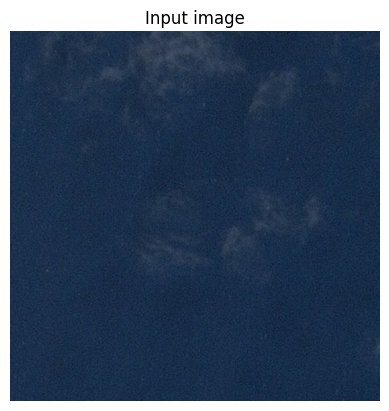

Size of image (768, 768)
Image format JPEG
Mode of image RGB


In [15]:
image = Image.open(os.path.join(path_to_imgs, RLE_encodings['ImageId'][0]))
plt.imshow(image)
plt.title('Input image')
plt.axis('off')
plt.show()

print('Size of image', image.size)
print('Image format', image.format)
print('Mode of image', image.mode)

Now let's look closer on this images and its' masks:

/tmp/ipykernel_34/848593866.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_id = row[0]
/tmp/ipykernel_34/848593866.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rle_string = str(row[1])


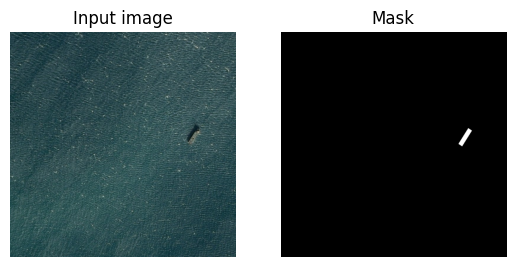

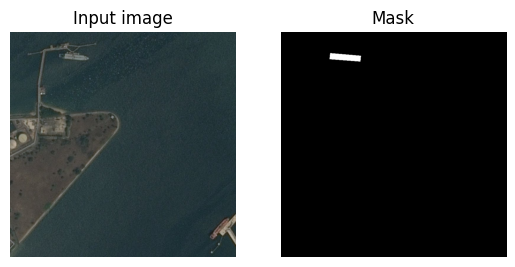

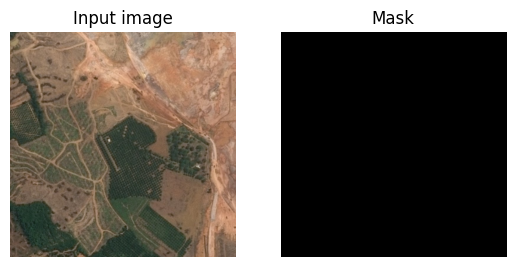

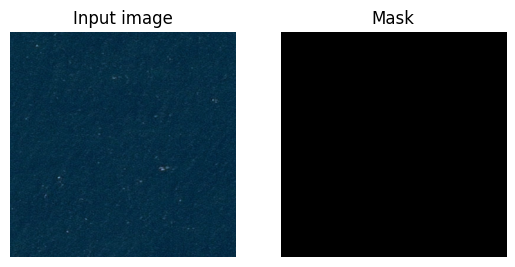

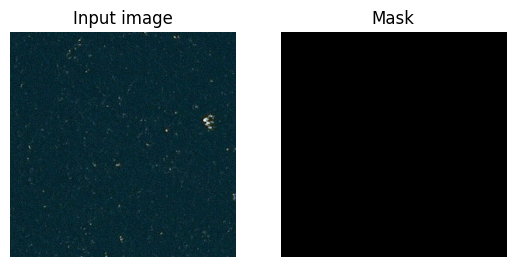

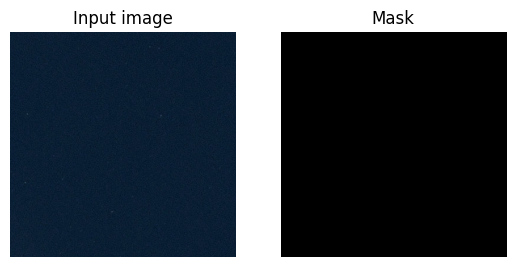

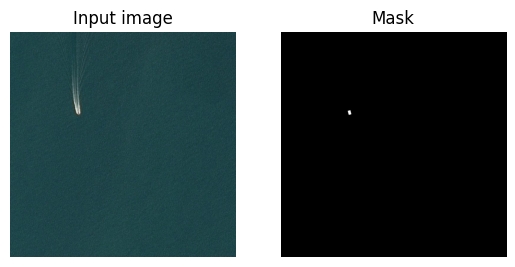

In [25]:
def create_mask(encoded_pixels, shape=(768, 768)):
    decoded_mask = np.zeros(shape, dtype=np.uint8)
    
    if encoded_pixels != 'nan' and len(encoded_pixels) != 0:
        pairs = np.array(encoded_pixels.split(), dtype=np.int32)
        start = pairs[::2] # Extract starting positions
        length = pairs[1::2] # Extract lengths of runs
        row = start // shape[1] # Calculate row indices using image width
        col = start % shape[1] # Calculate column indices using image width
        for r, c, l in zip(row, col, length):
            decoded_mask[r, c:c + l] = 255
        decoded_mask = decoded_mask.T
    return decoded_mask


def decode_and_visualize(image_id, encoded_pixels):
    mask = create_mask(encoded_pixels)
    image = Image.open(os.path.join(path_to_imgs, image_id))
    
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Input image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')
    plt.axis('off')

    plt.show()
    

for index, row in RLE_encodings.sample(7).iterrows():
    image_id = row[0]
    rle_string = str(row[1])
    decode_and_visualize(image_id, rle_string)
    

How we can see ships that we are going to segment occupy a significantly smaller area of the image than the background it will be a problem, especially considering that 65 percent of the images for training do not contain ships at all. So I think that splitting the task into two-- ship detection and ship segmentation and training the segmentation model only on images with ships is a good idea.  
Finally, let's take a look at the color distribution on images with/without ships:

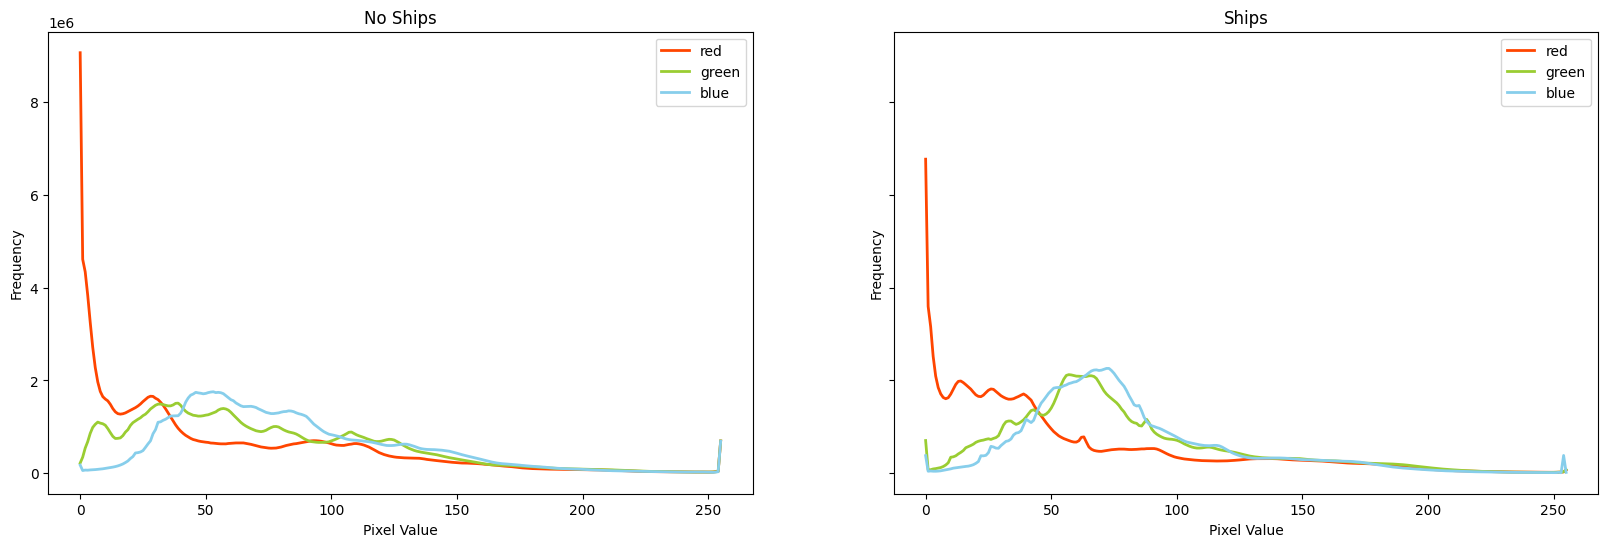

In [29]:
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row')
fig.set_size_inches(20, 6)

mask = RLE_encodings.EncodedPixels.isna()
for i, (msk, label) in enumerate(zip([mask, ~mask], ['No Ships', 'Ships'])):
    _ids = RLE_encodings[msk].ImageId.sample(250)
    imgs = np.array([plt.imread(os.path.join(path_to_imgs, _id)) for _id in _ids])
    
    red = imgs[:, :, :, 0]
    green = imgs[:, :, :, 1]
    blue = imgs[:, :, :, 2]
    
    ax[i].plot(np.bincount(red.ravel()), color='red', label='red', lw=2)
    ax[i].plot(np.bincount(green.ravel()), color='green', label='green', lw=2)
    ax[i].plot(np.bincount(blue.ravel()), color='blue', label='blue', lw=2)
    ax[i].legend()
    ax[i].title.set_text(label)
    ax[i].set_ylabel('Frequency')
    ax[i].set_xlabel('Pixel Value')


How we can see green and blue plots of images with ship differs from images with no ships.